In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:

# Reshape to add the channel dimension (28,28) → (28,28,1)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [ ]:
#  Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 62s 32ms/step - accuracy: 0.9046 - loss: 0.3172 - val_accuracy: 0.9855 - val_loss: 0.0460
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.9842 - loss: 0.0515 - val_accuracy: 0.9869 - val_loss: 0.0398
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.9893 - loss: 0.0331 - val_accuracy: 0.9888 - val_loss: 0.0330
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 30ms/step - accuracy: 0.9923 - loss: 0.0235 - val_accuracy: 0.9889 - val_loss: 0.0310
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - accuracy: 0.9947 - loss: 0.0179 - val_accuracy: 0.9910 - val_loss: 0.0282


In [ ]:
model.save("mnist_cnn.h5")


test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9881 - loss: 0.0369

 Test accuracy: 0.9910


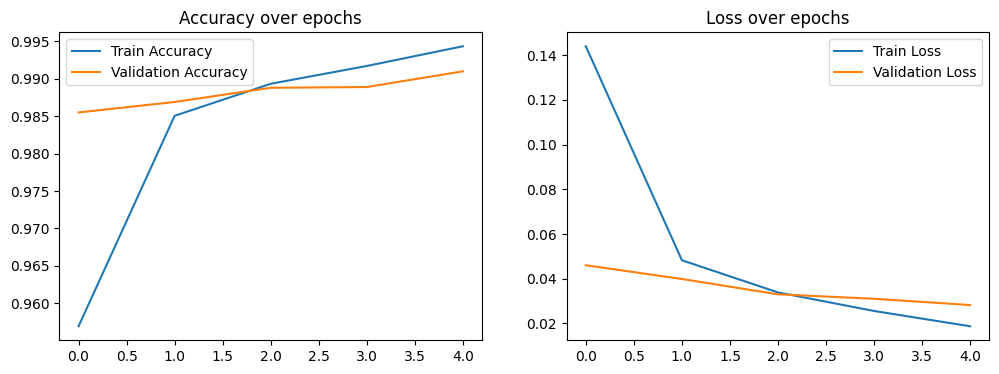

In [ ]:

#  Plot training accuracy and loss
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.show()

In [ ]:
import gradio as gr
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import traceback

# Load the trained model
model = load_model("mnist_cnn.h5")
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Prediction function
def predict_digit(img):
    try:
        if img is None:
            return {}, "Error: No image received!"

        # Handle Gradio dict inputs (Sketchpad sometimes returns dict)
        if isinstance(img, dict):
            if "image" in img:
                img = img["image"]
            elif "composite" in img:
                img = img["composite"]
            elif "mask" in img:
                img = img["mask"]
            else:
                return {}, f"Error: Unexpected dict keys: {list(img.keys())}"

        # Convert to numpy array
        img = np.array(img, dtype=np.uint8)

        # Convert to grayscale if it's RGB or RGBA
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Resize to 28x28
        img = cv2.resize(img, (28, 28))

        # Invert colors (Gradio sketchpad is white background)
        img = 255 - img

        # Normalize
        img = img / 255.0

        # Reshape to match model input
        img = img.reshape(1, 28, 28, 1)

        # Predict
        pred = model.predict(img)
        digit = int(np.argmax(pred))
        confidence = float(np.max(pred))

        # Return probabilities for each class and a text summary
        return {str(i): float(pred[0][i]) for i in range(10)}, f"Predicted: {digit} (confidence: {confidence:.2f})"

    except Exception as e:
        traceback.print_exc()
        return {}, f"Error: {str(e)}"

# Gradio interface
interface = gr.Interface(
    fn=predict_digit,
    inputs=gr.Sketchpad(canvas_size=(200, 200), label="Draw a digit (0–9)"),
    outputs=[gr.Label(num_top_classes=10, label="Confidence"), gr.Textbox(label="Result")],
    title=" Handwritten Digit Recognizer",
    description="Draw a digit (0–9) and the model will predict it."
)

# Launch interface
interface.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e7762b83976bb1e789.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
